In [730]:
import itertools
import time

from torch.onnx.ops import symbolic

from cirkit.backend.torch.circuits import TorchCircuit
from cirkit.backend.torch.parameters.nodes import TorchTensorParameter
from cirkit.backend.torch.parameters.parameter import TorchParameter
from cirkit.symbolic.io import plot_circuit
from cirkit.templates import data_modalities, utils
from cirkit.pipeline import compile
from notebooks.datasets import sample_rings
import matplotlib.pyplot as plt
import torch
import numpy as np


In [731]:
torch.manual_seed(42)

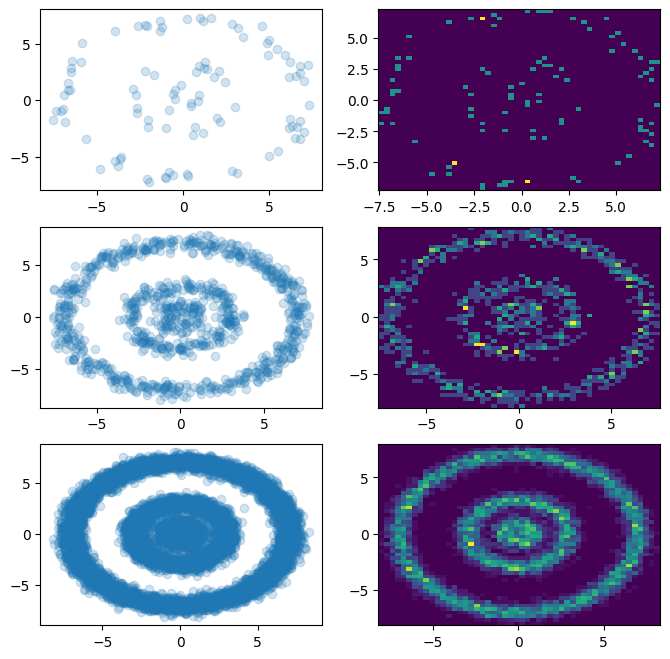

In [732]:
fig, rows = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
for (ax_scat, ax_hist), n in zip(rows, [100, 1_000, 10_000]):
    ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.4)
    ax_scat.scatter(ring_samples[:, 0], ring_samples[:, 1], alpha=0.2)
    ax_hist.hist2d(ring_samples[:, 0], ring_samples[:, 1], bins=(50, 50))

n = 10_000
ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.5)
ring_samples = np.float32(ring_samples)

In [733]:
from cirkit.pipeline import PipelineContext
from cirkit.symbolic.circuit import Circuit
from cirkit.utils.scope import Scope
from cirkit.symbolic.layers import GaussianLayer, HadamardLayer, SumLayer, KroneckerLayer

device = torch.device("cpu")
def new_circuit():

    weight_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='uniform'
    ))
    mean_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='normal',
        initialization_kwargs={"mean": -2, "stddev": 1}
    ))
    stddev_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='normal',
        initialization_kwargs={"mean": 2, "stddev": 1}
    ))

    g0 = GaussianLayer(Scope((0,)), 2, mean_factory=mean_factory, stddev_factory=stddev_factory)
    g1 = GaussianLayer(Scope((1,)), 2, mean_factory=mean_factory, stddev_factory=stddev_factory)
    prod = HadamardLayer(num_input_units=2, arity=2)
    sl = SumLayer(2, 1, 1, weight_factory=weight_factory)

    symbolic_circuit = Circuit(
        layers=[g0, g1, prod, sl],
        in_layers={
            g0: [],
            g1: [],
            prod: [g0, g1],
            sl: [prod],
        },
        outputs=[sl]
    )
    pctx = PipelineContext(backend="torch", semiring="lse-sum", fold=True, optimize=False)
    circuit = compile(symbolic_circuit, pctx)
    circuit = circuit.to(device)
    return symbolic_circuit, circuit

symbolic_circuit, circuit = new_circuit()


Number of variables: 2
Structural properties:
 - Smoothness: True
 - Decomposability: True
 - Structured-decomposability: True
Number of layers: 3
Number of learnable parameters: 10



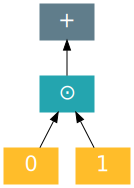

In [734]:
print(f"""
Number of variables: {symbolic_circuit.num_variables}
Structural properties:
 - Smoothness: {symbolic_circuit.is_smooth}
 - Decomposability: {symbolic_circuit.is_decomposable}
 - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}
Number of layers: {len(list(circuit.layers))}
Number of learnable parameters: {sum(p.numel() for p in circuit.parameters())}
""")
plot_circuit(symbolic_circuit)

In [735]:
# from torch import optim
#
# symbolic_circuit, circuit = new_circuit()
# optimizer = optim.Adam(circuit.parameters(), lr=0.01)
# LLs_fullbatch = []
# time_fullbatch = time.time()
# for epoch_idx in range(1000):
#     batch = ring_samples
#     batch = torch.from_numpy(batch).to(device)
#
#     log_likelihoods = circuit(batch)
#
#     loss = -torch.mean(log_likelihoods)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#
#     LLs_fullbatch.append(-loss.detach())
# time_fullbatch = time.time() - time_fullbatch
#
#
# symbolic_circuit, circuit = new_circuit()
# optimizer = optim.Adam(circuit.parameters(), lr=0.01)
# LLs_minibatch = []
# time_minibatch = time.time()
# for epoch_idx in range(100):
#     for i, batch in enumerate(np.vsplit(ring_samples, 10)):
#         batch = torch.from_numpy(batch).to(device)
#
#         log_likelihoods = circuit(batch)
#
#         loss = -torch.mean(log_likelihoods)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#         LLs_minibatch.append(-loss.detach())
# time_minibatch = time.time() - time_minibatch
#
# print(f"Full-batch time: {time_fullbatch * 1000:.0f}ms")
# print(f"Minibatch time: {time_minibatch * 1000:.0f}ms")
#
# plt.plot(np.arange(len(LLs_fullbatch)), LLs_fullbatch, label="Full-batch")
# plt.plot(np.arange(len(LLs_minibatch)), LLs_minibatch, label="Minibatch")
# plt.legend()
# plt.show()

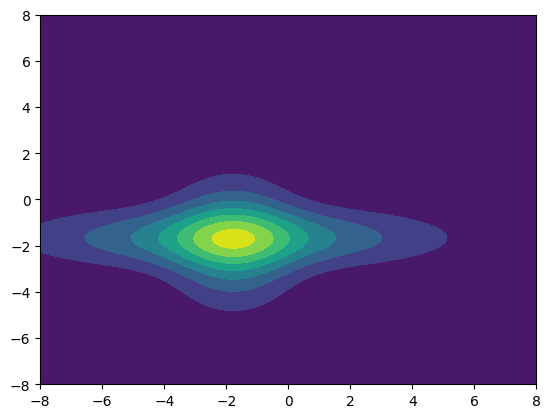

In [736]:
def plot_circuit_distribution_2d(circuit, data=None, ax=plt):
    x = np.float32(np.linspace(-8, 8, 100))
    y = np.float32(np.linspace(-8, 8, 100))

    X, Y = np.meshgrid(x, y)

    xy = itertools.product(x, y)
    xy = torch.tensor(list(xy))
    Z = circuit(xy).detach().exp().numpy().reshape(100, 100)


    ax.contourf(X, Y, Z)
    # ax.colorbar()

    if data is not None:
        ax.scatter(data[:, 0], data[:, 1], color="red", marker="x")

plot_circuit_distribution_2d(circuit)

In [737]:
class AutoGridPlotter:
    def __init__(self, cols=3, rows=3):
        self.fig = plt.figure(figsize=(12, 12))
        self.axs = self.fig.subplots(rows, cols).flatten()
        self.idx = 0
        self.n = len(self.axs)
        self.rows = rows
        self.cols = cols

    def next_ax(self):
        ax = self.axs[self.idx]
        self.idx = self.idx + 1
        ax.title.set_text(f"i={self.idx}")
        if self.idx >= self.n:
            self.show()
            self.fig = plt.figure()
            self.axs = self.fig.subplots(self.rows, self.cols).flatten()
            self.idx = 0
            self.n = len(self.axs)
        return ax

    def show(self):
        self.fig.show()


new_weights=tensor([[[0.6755, 0.3245]]])
mu_update=tensor([[-0.8972,  0.8863],
        [-0.8972,  0.8863]]) std_update=tensor([[2.1447, 1.9427],
        [2.1447, 1.9427]])
new_weights=tensor([[[0.6956, 0.3044]]])
mu_update=tensor([[-0.7588,  1.7793],
        [-0.7588,  1.7793]]) std_update=tensor([[2.3399, 0.7180],
        [2.3399, 0.7180]])
new_weights=tensor([[[0.4587, 0.5413]]])
mu_update=tensor([[-1.8164,  1.8449],
        [-1.8164,  1.8449]]) std_update=tensor([[1.9623, 0.4654],
        [1.9623, 0.4654]])
new_weights=tensor([[[0.1485, 0.8515]]])
mu_update=tensor([[-2.5196,  1.8192],
        [-2.5196,  1.8192]]) std_update=tensor([[1.3516, 0.4777],
        [1.3516, 0.4777]])
new_weights=tensor([[[0.0620, 0.9380]]])
mu_update=tensor([[-3.0480,  1.7834],
        [-3.0480,  1.7834]]) std_update=tensor([[0.1019, 0.4913],
        [0.1019, 0.4913]])
new_weights=tensor([[[0.8170, 0.1830]]])
mu_update=tensor([[-3.0500,  1.7833],
        [-3.0500,  1.7833]]) std_update=tensor([[0.0500, 0.49

/tmp/ipykernel_105367/2848671858.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


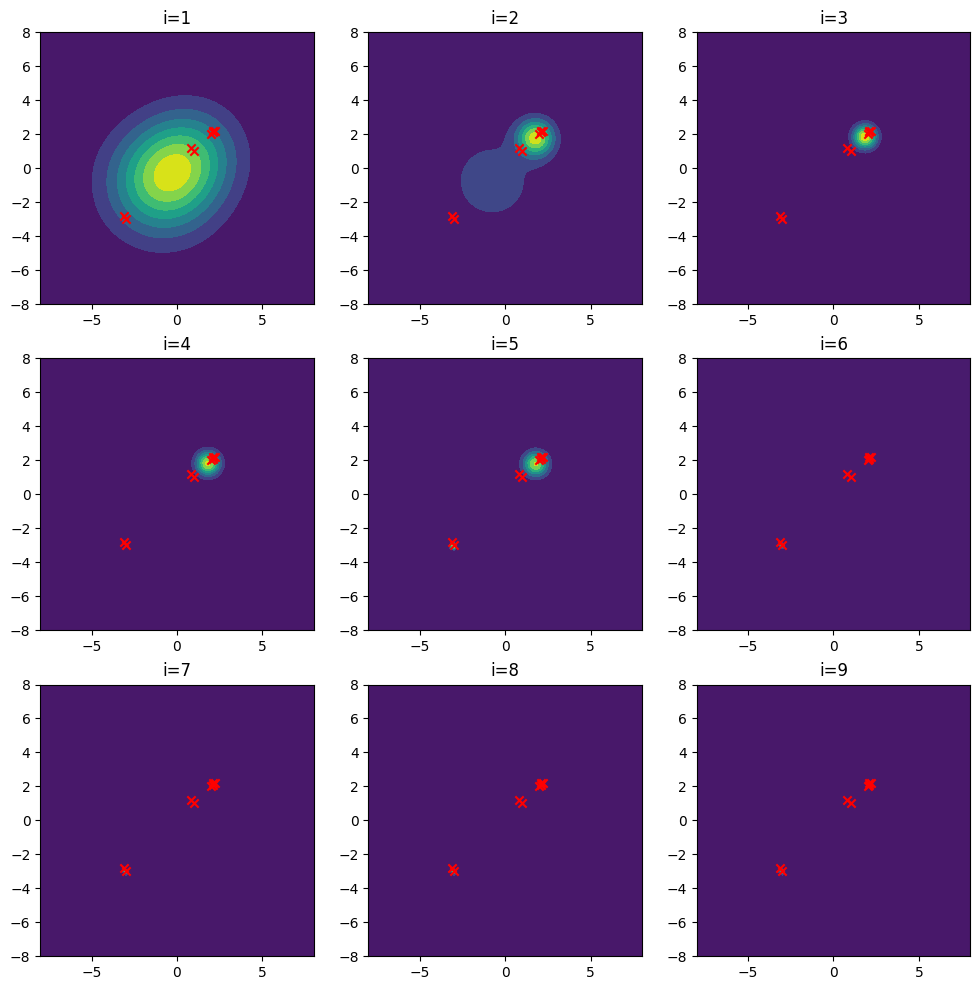

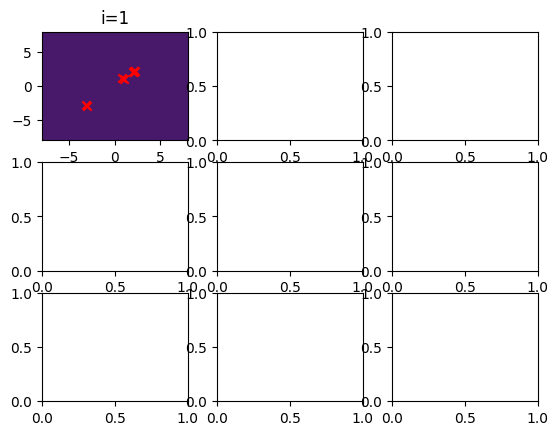

In [738]:
from cirkit.backend.torch.layers import TorchInnerLayer, TorchSumLayer, TorchGaussianLayer


def print_tensor_stats(t):
    print(f"""
    n: {t.numel()}
    elems: {t}
""")

def update_params_nested(params: TorchParameter, new_values: torch.Tensor):
    for p in params.outputs:
        if type(p) == TorchTensorParameter:
            p.update_params(new_values.squeeze())

class FullBatchEM:
    def __init__(self, circuit):
        self.circuit = circuit

        self.inner_layer_params = {}
        self.inner_layer_inputs = {}
        self.inner_layer_outputs = {}

        self.leave_layer_params = {}
        self.leave_layer_inputs = {}
        self.leave_layer_outputs = {}

        self.weighted_counts = {}
        self.current_weights = {}
        self.suff_stats_x = {}
        self.suff_stats_x_2 = {}
        self.leaf_posterior_per_batch = {}

        for l in circuit.modules():
            if isinstance(l, TorchSumLayer):
                self.inner_layer_params[l] = l.weight
                self.inner_layer_inputs[l] = None
                self.inner_layer_outputs[l] = None
            if isinstance(l, TorchGaussianLayer):
                self.leave_layer_params[l] = l.params
                self.leave_layer_inputs[l] = None
                self.leave_layer_outputs[l] = None


    def _layer_fn(self, layer, *inputs):
        output = layer(*inputs)
        if isinstance(layer, TorchGaussianLayer):
            self.leave_layer_inputs[layer] = inputs[0]
            output.retain_grad()
            self.leave_layer_outputs[layer] = output

        elif isinstance(layer, TorchSumLayer):
            self.inner_layer_inputs[layer] = inputs[0]
            output.retain_grad()
            self.inner_layer_outputs[layer] = output
        return output

    def e_weights(self, log_likelihoods_per_sample):
        for sum_layer in self.inner_layer_outputs:
            with torch.no_grad():
                inputs = self.inner_layer_inputs[sum_layer]
                outputs = self.inner_layer_outputs[sum_layer]
                outputs_grad = outputs.grad
                weight_params = self.inner_layer_params[sum_layer]
                weights = weight_params()

                responsibility = outputs_grad * inputs

                weighted_count_per_sample = responsibility * weights
                weighted_counts = weighted_count_per_sample.sum(dim=2)
                self.weighted_counts[sum_layer] = weighted_counts
                self.current_weights[sum_layer] = weights

    def m_weights(self):
        for sum_layer in self.inner_layer_outputs:
            with torch.no_grad():
                weighted_counts = self.weighted_counts[sum_layer]
                current_weights = self.current_weights[sum_layer]
                total_count = weighted_counts.sum()
                new_weights = weighted_counts / total_count

                print(f"{new_weights=}")

                update_params_nested(self.inner_layer_params[sum_layer], new_weights)

    def e_leaves(self, log_likelihoods_per_sample, data_full):
        for leaf in self.leave_layer_params:
            with torch.no_grad():
                outputs = self.leave_layer_outputs[leaf]
                outputs_grad = outputs.grad

                x = data_full[:,leaf.scope_idx].squeeze()
                x_2 = x ** 2

                posterior_per_sample = outputs_grad

                suff_stats_x = posterior_per_sample * x
                suff_stats_x_2 = posterior_per_sample * x_2
                leaf_posterior_per_batch = torch.sum(posterior_per_sample, dim=1)

                self.suff_stats_x[leaf] = suff_stats_x
                self.suff_stats_x_2[leaf] = suff_stats_x_2
                self.leaf_posterior_per_batch[leaf] = leaf_posterior_per_batch

    def m_leaves(self):
        for leaf in self.leave_layer_params:
            with torch.no_grad():
                posterior_per_batch_l = self.leaf_posterior_per_batch[leaf]
                mean = torch.sum(self.suff_stats_x[leaf], dim=1) / posterior_per_batch_l
                var = (torch.sum(self.suff_stats_x_2[leaf], dim=1) / posterior_per_batch_l) - (mean ** 2)

                mu_update = mean
                var = torch.clamp(var, min=1e-3)
                std_update = torch.sqrt(var)

                print(f"{mu_update=} {std_update=}")

                update_params_nested(leaf.params["mean"], mu_update)
                update_params_nested(leaf.params["stddev"], std_update)


    def step(self, data):
        log_likelihoods_per_sample = self.circuit.evaluate(data, module_fn=self._layer_fn)
        log_likelihoods_per_sample.sum().backward()
        self.e_weights(log_likelihoods_per_sample)
        self.e_leaves(log_likelihoods_per_sample, data)
        self.m_weights()
        self.m_leaves()
        return log_likelihoods_per_sample.sum()

em = FullBatchEM(circuit)
data = torch.tensor([[1.0, 1.0], [0.8, 1.2], [2.0, 2.0], [2.1, 2.2], [2.2, 2.2], [2.1, 2.1], [-3, -3], [-3.1, -2.8]])
em_losses = []
grid_plotter = AutoGridPlotter()
for i in range(10):
    # em.e_step(torch.from_numpy(ring_samples))

    # data = torch.tensor([[1.0, 1.0]])
    # data = torch.from_numpy(ring_samples)
    ll = em.step(data)
    plot_circuit_distribution_2d(circuit, data, ax=grid_plotter.next_ax())
    em_losses.append(ll.detach().numpy())
grid_plotter.show()


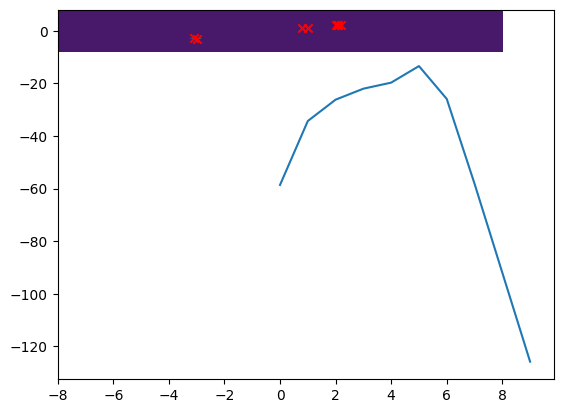

In [739]:
plt.plot(range(len(em_losses)), em_losses)

plot_circuit_distribution_2d(circuit, data)

In [740]:
print("Circuit training mode:", circuit.training)
for name, param in circuit.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

Circuit training mode: True
_nodes.0.mean._nodes.0._ptensor: requires_grad=True
_nodes.0.stddev._nodes.0._ptensor: requires_grad=True
_nodes.2.weight._nodes.0._ptensor: requires_grad=True
